In [1]:
import pandas as pd
import plotly.express as px
from dotenv import load_dotenv
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import ta

In [2]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# Load Alpaca credentials
load_dotenv()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/niroren/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


False

In [3]:
def score_sentiment(news_df):
    news_df["sentiment"] = news_df["headline"].apply(lambda x: sid.polarity_scores(x)["compound"])
    print("done")
    return news_df

In [4]:
clean = pd.read_csv("data/cleaned_news.csv").drop(columns=['Unnamed: 0'])

# add sentiments, and extract date
news_df = score_sentiment(clean)
news_df.created_at = pd.to_datetime(news_df.created_at)
news_df['date'] = news_df.created_at.dt.date

done


In [5]:
tickers = ['AAPL','GOOGL']

In [6]:
ticker_news = {}
daily_sentiment = {}
for symbol in tickers:
    # extract news articles that have to do with the ticker
    ticker_news[symbol] = news_df[news_df['symbols'].apply(lambda x: f"'{symbol}'" in x)]
    
    # calculate average sentiment per day
    daily_sentiment[symbol] = ticker_news[symbol].groupby('date')['sentiment'].mean()


In [7]:
# merge sentiment, add other indicators

price_dfs = {}
for ticker in tickers:
    price_dfs[ticker] = pd.read_csv(f'data/{ticker}.csv').set_index('Date')
    price_dfs[ticker].index = pd.to_datetime(price_dfs[ticker].index,
                                             format="%Y-%m-%d"
                                             )
    price_dfs[ticker].sort_index(ascending=True)
    price_dfs[ticker]['news_sentiment'] = daily_sentiment[ticker]
    price_dfs[ticker]['return'] = price_dfs[ticker]['Close'].diff()
    price_dfs[ticker]['fwd_return'] = price_dfs[ticker]['Close'].diff().shift(-1)

    # EMA
    price_dfs[ticker]['ema'] = ta.trend.ema_indicator(
        price_dfs[ticker]['Close'], window=20)
    
    # RSI
    price_dfs[ticker]['rsi_14'] = ta.momentum.rsi(price_dfs[ticker]['Close'], window=14)

    # PVT
    price_dfs[ticker]['pvt'] = ta.volume.volume_price_trend(price_dfs[ticker]['Close'], price_dfs[ticker]['Volume'])

    # MACD
    price_dfs[ticker]['macd'] = ta.trend.macd(price_dfs[ticker]['Close'])
    price_dfs[ticker]['macd_signal'] = ta.trend.macd_signal(price_dfs[ticker]['Close'])
    price_dfs[ticker]['macd_diff'] = ta.trend.macd_diff(price_dfs[ticker]['Close'])

    price_dfs[ticker]['sma_20'] = ta.trend.sma_indicator(price_dfs[ticker]['Close'], window=20)
    price_dfs[ticker]['williams_r'] = ta.momentum.williams_r(price_dfs[ticker]['High'], price_dfs[ticker]['Low'], price_dfs[ticker]['Close'], lbp=14)
    price_dfs[ticker]['obv'] = ta.volume.on_balance_volume(price_dfs[ticker]['Close'], price_dfs[ticker]['Volume'])
    price_dfs[ticker]['atr'] = ta.volatility.average_true_range(price_dfs[ticker]['High'], price_dfs[ticker]['Low'], price_dfs[ticker]['Close'], window=14)

In [8]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [24]:
features = [
    "Open", "High", "Low", "Close", "Volume", "news_sentiment", "return",
    "ema", "rsi_14", "pvt", "macd", "macd_signal", "macd_diff"
]
target = "fwd_return"

trading_results = {}

for ticker in tickers:
    df = price_dfs[ticker].copy()
    df = df.dropna().sort_index()

    X = df[features]
    y = df[target]

    # scale volume and pvt 
    X["Volume"] = X["Volume"] / 1e6
    X["pvt"] = X["pvt"] / 1e6

    # test train, 20% test
    split_idx = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


    # X_train, X_test = X[X.index < "2025-01-01"], X[X.index >= "2025-01-01"]
    # y_train, y_test = y[y.index < "2025-01-01"], y[y.index >= "2025-01-01"]

    model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    results = pd.DataFrame(y_test)
    results['pred'] = y_pred

    results['actual_dir'] = results['fwd_return'].apply(np.sign)
    results['pred_dir'] = results['pred'].apply(np.sign)


    results['profit'] = results['pred'] * results['fwd_return']

    trading_results[ticker] = results
    

/var/folders/tl/d5lq85h96f396hsw76f77lxc0000gn/T/ipykernel_68453/544661462.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Volume"] = X["Volume"] / 1e6
/var/folders/tl/d5lq85h96f396hsw76f77lxc0000gn/T/ipykernel_68453/544661462.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["pvt"] = X["pvt"] / 1e6
/var/folders/tl/d5lq85h96f396hsw76f77lxc0000gn/T/ipykernel_68453/544661462.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [25]:
profit = {}

for ticker in tickers:
    profit[ticker] = trading_results[ticker]['profit'].sum()

print("If trading based on the signal, the profit from",trading_results[ticker].index.min().date(),'to',trading_results[ticker].index.max().date(),'is')
print(profit)


print("\nsum profit:")
print(sum(profit.values()))

If trading based on the signal, the profit from 2024-09-10 to 2025-05-01 is
{'AAPL': 775.9223918560517, 'GOOGL': 177.53590337267198}

sum profit:
953.4582952287237


In [28]:
trading_results['AAPL']['profit'].sort_index(ascending=True)

Date
2024-09-09    0.069277
2024-09-10   -1.714039
2024-09-11    5.569975
2024-09-12   -0.030591
2024-09-13   -0.030718
                ...   
2025-04-25   -0.279554
2025-04-28    0.922864
2025-04-29    1.186708
2025-04-30   -1.201203
2025-05-01   -0.233868
Name: profit, Length: 161, dtype: float64

<Axes: xlabel='Date'>

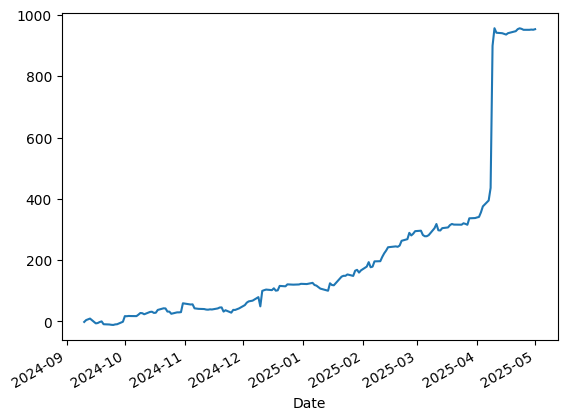

In [29]:
(trading_results['AAPL']['profit']+trading_results['GOOGL']['profit']).cumsum().plot()